In [91]:
import os,time
import glob
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
inputDir = '../data/train'
testDir = '../data/validation'
outputDir = 'output'
from random import shuffle



In [92]:
def myshow(img, title=None, margin=0.05, dpi=100):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (4 + margin) * ysize / dpi, (4 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
   
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

In [93]:
def loadData( inputDir, padding=0 ):
    imageflairFilenames = glob.glob(os.path.join(inputDir, "Utrecht", "*","pre","FLAIR.nii.gz"))
    imageT1Filenames = glob.glob(os.path.join(inputDir, "Utrecht", "*","pre","T1.nii.gz"))
    labelFilenames= glob.glob(os.path.join(inputDir, "Utrecht", "*","wmh.nii.gz"))
    images = None # shape: (numImages, z, y, x, channels=1)
    labels = None
    masks  = None
    print(len(imageflairFilenames))
    for imageflairFilenames, imageT1Filenames, labelFilenames in zip(imageflairFilenames, imageT1Filenames, labelFilenames):
        # Load the images
        flairImage = sitk.ReadImage(imageflairFilenames)
        T1Image = sitk.ReadImage(imageT1Filenames)
        labelImage = sitk.ReadImage(labelFilenames)
        # Convert to arrays
        flairArray = np.pad(sitk.GetArrayFromImage(flairImage), [(0,0),(padding,padding),(padding,padding)], 'constant')
        T1Array = np.pad(sitk.GetArrayFromImage(T1Image), [(0,0),(padding,padding),(padding,padding)], 'constant')
        labelArray = np.pad(sitk.GetArrayFromImage(labelImage), [(0,0),(padding,padding),(padding,padding)], 'constant')
        maskArray = labelArray > 0
        print("flairArray",flairArray.shape)
        print("T1Array",T1Array.shape)
        print("labelArray",labelArray.shape)
        print("maskArray",maskArray.shape)
        # Add to the images/labels array
        if images is None:
            images = flairArray.reshape([1] + list(flairArray.shape) + [1])
            images = np.concatenate([images, T1Array.reshape([1] + list(T1Array.shape) + [1])], axis=4)
            labels = labelArray.reshape([1] + list(labelArray.shape) + [1])
            masks  = maskArray.reshape([1] + list(maskArray.shape) + [1])
        else:
            tempArray = np.concatenate([flairArray.reshape([1] + list(flairArray.shape) + [1]), T1Array.reshape([1] + list(T1Array.shape) + [1])], axis=4)
            
            images = np.concatenate([images, tempArray])
            
            labels = np.concatenate([labels, labelArray.reshape([1] + list(labelArray.shape) + [1])])
            masks  = np.concatenate([masks, maskArray.reshape([1] + list(maskArray.shape) + [1])])
                    
    return images, labels, masks

In [94]:
testImages, testLabels, testMasks = loadData(testDir)
testNonZeroIdx = np.nonzero(testMasks)
trainImages, trainLabels, trainMasks = loadData(inputDir)
trainNonZeroIdx = np.nonzero(testMasks)

5
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
15
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 240)
flairArray (48, 240, 240)
T1Array (48, 240, 240)
labelArray (48, 240, 240)
maskArray (48, 240, 

In [95]:
testMasks.shape[0]

5

In [96]:
trainMasks.shape

(15, 48, 240, 240, 1)

In [97]:
trainimages = []
trainlables = []
for i in range(trainMasks.shape[0]):
    for j in range(trainMasks.shape[1]):
        if not np.all(trainMasks[i,j,:,:,0]== False):
            trainlables.append(trainLabels[i,j,:,:,:])
            trainimages.append(trainImages[i,j,:,:,:])

testimages = []
testlables = []
for i in range(testMasks.shape[0]):
    for j in range(testMasks.shape[1]):
        if not np.all(testMasks[i,j,:,:,0]== False):
            testlables.append(testLabels[i,j,:,:,:])
            testimages.append(testImages[i,j,:,:,:])

In [98]:
X = np.asarray(trainimages)
y = np.asarray(trainlables).astype(int)
y[y >1] = 0
print(X.shape, X.min(), X.max()) # (240, 240, 4) -0.380588 2.62761
print(y.shape, y.min(), y.max()) # (240, 240, 1) 0 1 

Xtest = np.asarray(testimages)
ytest = np.asarray(testlables).astype(int)
ytest[ytest >1] = 0
print(Xtest.shape, Xtest.min(), Xtest.max()) # (240, 240, 4) -0.380588 2.62761
print(ytest.shape, ytest.min(), ytest.max()) # (240, 240, 1) 0 1 

(402, 240, 240, 2) 0.0 3168.0
(402, 240, 240, 1) 0 1
(138, 240, 240, 2) 0.0 2641.0
(138, 240, 240, 1) 0 1


In [99]:


def shuffle_list(*ls):
    l =list(zip(*ls))
    shuffle(l)
    return zip(*l)

Xs,ys = shuffle_list(X,y)
Xs= np.array(Xs)
ys= np.array(ys)
print(Xs.shape)
print(ys.shape)


(402, 240, 240, 2)
(402, 240, 240, 1)


## U net

In [100]:
from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout,UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [101]:
def get_unet():
    inputs = Input(batchShape[1:])
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = -1)
    conv6 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = -1)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = -1)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = -1)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)


    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    model.summary()
    return model

In [102]:
def preprocess(imgs):
#   print("pree",imgs.shape, imgs.shape[:-1])
    imgs_p = np.ndarray((imgs.shape[0],img_rows, img_cols,imgs.shape[-1]), dtype=np.uint8)
#     print("imgs.shape[0]",imgs.shape[0])
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i],(img_cols, img_rows,imgs.shape[-1]), preserve_range=True)
  
#   print("imgs_p",imgs_p.shape)
    return imgs_p

In [103]:
def train(X,y):
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = np.array(X), np.array(y)#load_train_data()
#     myshow(sitk.GetImageFromArray(imgs_train[:,:,0]))
#     myshow(sitk.GetImageFromArray(imgs_train[:,:,1]))
#     myshow(sitk.GetImageFromArray(imgs_mask_train))
#     print("shape before",imgs_train.shape,imgs_mask_train.shape)
#     myshow(sitk.GetImageFromArray(imgs_train))

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)
#     print("shapeagfter",imgs_train.shape,imgs_mask_train.shape)
#     myshow(sitk.GetImageFromArray(imgs_train))

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train /= 255.  # scale masks to [0, 1]

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
# #     myshow(sitk.GetImageFromArray(imgs_train))
#     myshow(sitk.GetImageFromArray(imgs_mask_train))
#     print("before model",imgs_train.shape,imgs_mask_train.shape)
    model.fit(imgs_train, imgs_mask_train, batch_size=20, nb_epoch=1, verbose=1, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint])
    
    return model
   
def predict(model):    
    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    testrange = range(len(ytest))
    imgs_test, imgs_id_test = Xtest, ytest
#     print("before test pre",imgs_test.shape,imgs_id_test)
    imgs_test = preprocess(imgs_test)
#     print("after test pre",imgs_test.shape,imgs_id_test)
    imgs_test = imgs_test.astype('float32')
    mean = np.mean(imgs_test)  # mean for data centering
    std = np.std(imgs_test)  # std for data normalization
    imgs_test -= mean
    imgs_test /= std

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('weights.h5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
#     print("test model",imgs_test.shape)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    print("test model finished",imgs_mask_test.shape)
    np.save('imgs_mask_test.npy', imgs_mask_test)
    myshow(sitk.GetImageFromArray(imgs_test[30,:,:,1]))
    myshow(sitk.GetImageFromArray(imgs_id_test[30,:,:,0]))
    myshow(sitk.GetImageFromArray(imgs_mask_test[30,:,:,0]))
    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    pred_dir = 'preds'
    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)
    for image, image_id in zip(imgs_mask_test, testrange):
#         print(image_id)
        nn = 0
#         print(image.shape)
        image = (image[:, :, 0] * 255.).astype(np.uint8)
        imsave(os.path.join(pred_dir,str(image_id) + '_pred.png'), image)
        nn+=1
    print(imgs_id_test.shape,imgs_mask_test.shape)
    return imgs_id_test,imgs_mask_test

In [104]:
img_rows =240
img_cols =240

smooth = 1.

batchSize = 20
batchShape = (batchSize, 240,240, 2)

In [105]:

Xchunks = [Xs[x:x+100] for x in range(0, len(Xs), 100)]
ychunks = [ys[x:x+100] for x in range(0, len(ys), 100)]


------------------------------
Loading and preprocessing train data...
------------------------------


C:\Users\Jing\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Jing\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


------------------------------
Creating and compiling model...
------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 240, 240, 2)  0                                            
__________________________________________________________________________________________________
conv2d_625 (Conv2D)             (None, 240, 240, 32) 608         input_27[0][0]                   
__________________________________________________________________________________________________
conv2d_626 (Conv2D)             (None, 240, 240, 32) 9248        conv2d_625[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_105 (MaxPooling2D (None, 120, 120, 32) 0           conv2d_626[0][0]                 
_______________

C:\Users\Jing\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 80 samples, validate on 20 samples
Epoch 1/1
80/80 [==============================] - 71s 891ms/step - loss: 0.3786 - acc: 0.9823 - val_loss: 0.2353 - val_acc: 0.9926
------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 240, 240, 2)  0                                            
__________________________________________________________________________________________________
conv2d_649 (Conv2D)             (None, 240, 240, 32) 608         input_28[0][0]                   
__________________________________________________________________________________________________
conv2d_650 (Conv2D)             (N

Train on 80 samples, validate on 20 samples
Epoch 1/1
80/80 [==============================] - 71s 893ms/step - loss: 0.5092 - acc: 0.9960 - val_loss: 0.3449 - val_acc: 0.9940
------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 240, 240, 2)  0                                            
__________________________________________________________________________________________________
conv2d_673 (Conv2D)             (None, 240, 240, 32) 608         input_29[0][0]                   
__________________________________________________________________________________________________
conv2d_674 (Conv2D)             (N

Train on 80 samples, validate on 20 samples
Epoch 1/1
80/80 [==============================] - 71s 885ms/step - loss: 0.2397 - acc: 0.9958 - val_loss: 0.1741 - val_acc: 0.9959
------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 240, 240, 2)  0                                            
__________________________________________________________________________________________________
conv2d_697 (Conv2D)             (None, 240, 240, 32) 608         input_30[0][0]                   
__________________________________________________________________________________________________
conv2d_698 (Conv2D)             (N

Train on 80 samples, validate on 20 samples
Epoch 1/1
80/80 [==============================] - 71s 890ms/step - loss: 0.7223 - acc: 0.7463 - val_loss: 0.6963 - val_acc: 0.9599
------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 240, 240, 2)  0                                            
__________________________________________________________________________________________________
conv2d_721 (Conv2D)             (None, 240, 240, 32) 608         input_31[0][0]                   
__________________________________________________________________________________________________
conv2d_722 (Conv2D)             (N

Train on 1 samples, validate on 1 samples
Epoch 1/1
1/1 [==============================] - 8s 8s/step - loss: 0.7142 - acc: 0.8977 - val_loss: 0.7095 - val_acc: 0.9017
------------------------------
Loading and preprocessing test data...
------------------------------
------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
138/138 [==============================] - 33s 240ms/step
test model finished (138, 240, 240, 1)
------------------------------
Saving predicted masks to files...
------------------------------
(138, 240, 240, 1) (138, 240, 240, 1)


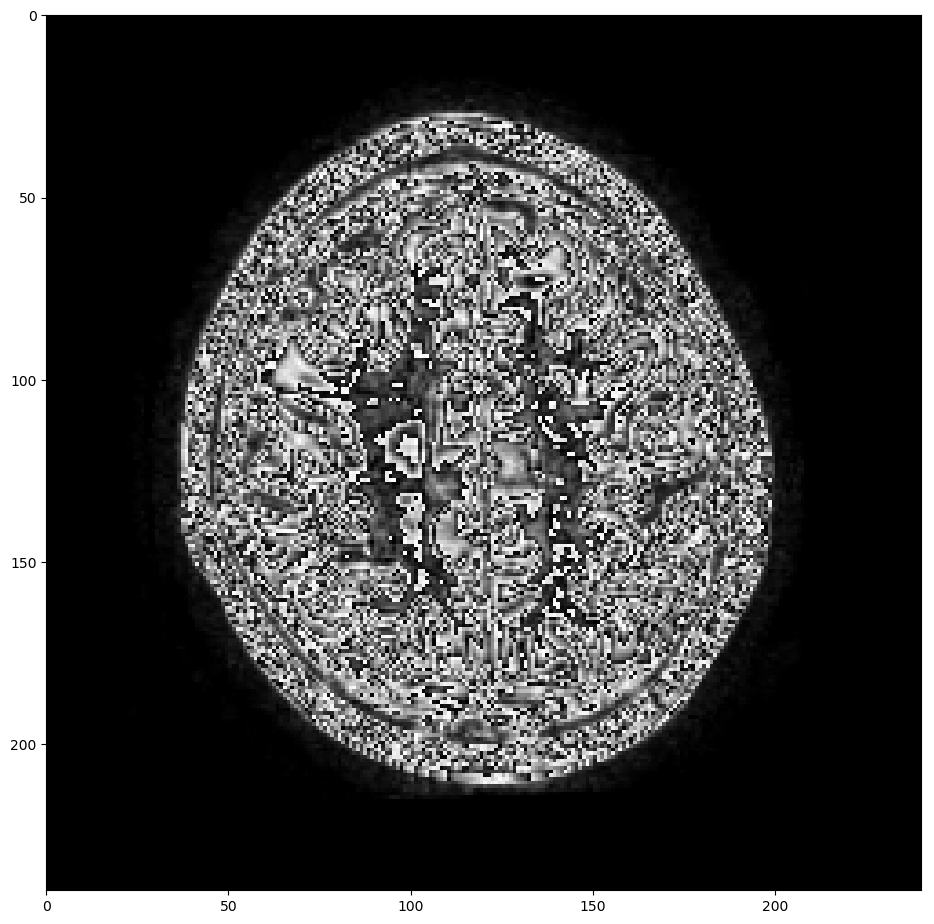

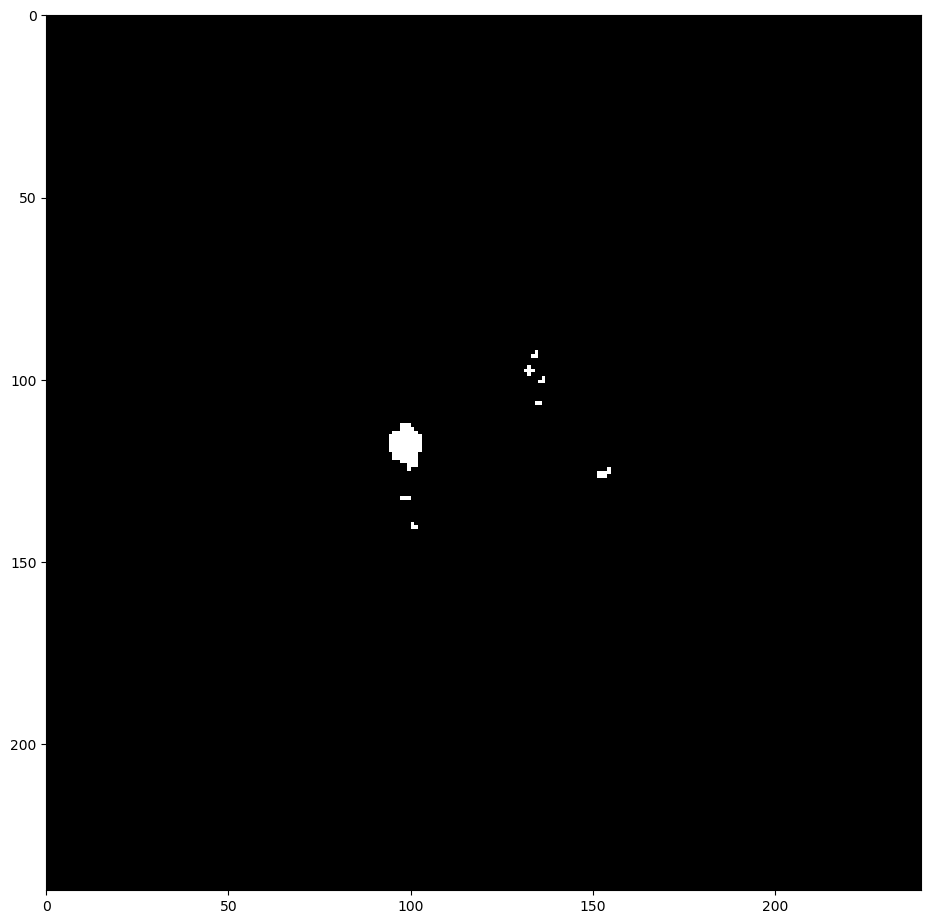

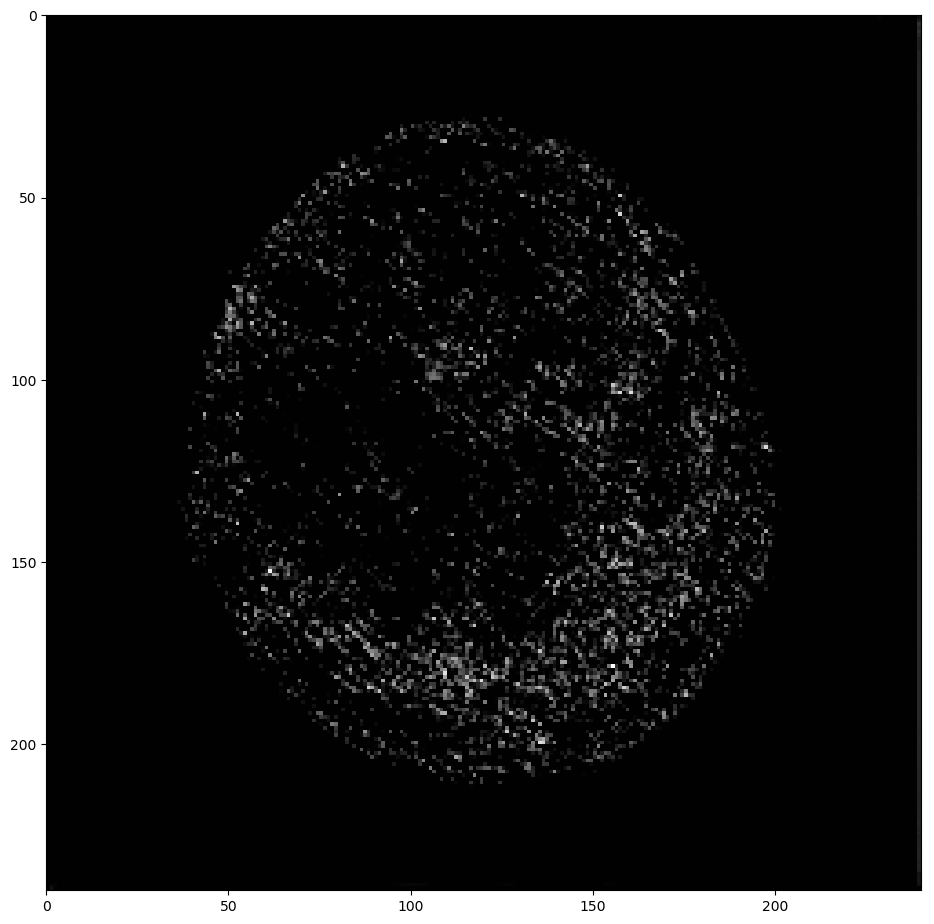

In [106]:
if __name__ == '__main__':
    for i,j in zip(Xchunks[-5:],ychunks[-5:]):
        model = train(i,j)
    testFilename, resultFilename = predict(model)

------------------------------
Loading and preprocessing test data...
------------------------------


C:\Users\Jing\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Jing\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
138/138 [==============================] - 35s 254ms/step
test model finished (138, 256, 256, 1)
------------------------------
Saving predicted masks to files...
------------------------------
(138, 240, 240, 1) (138, 256, 256, 1)


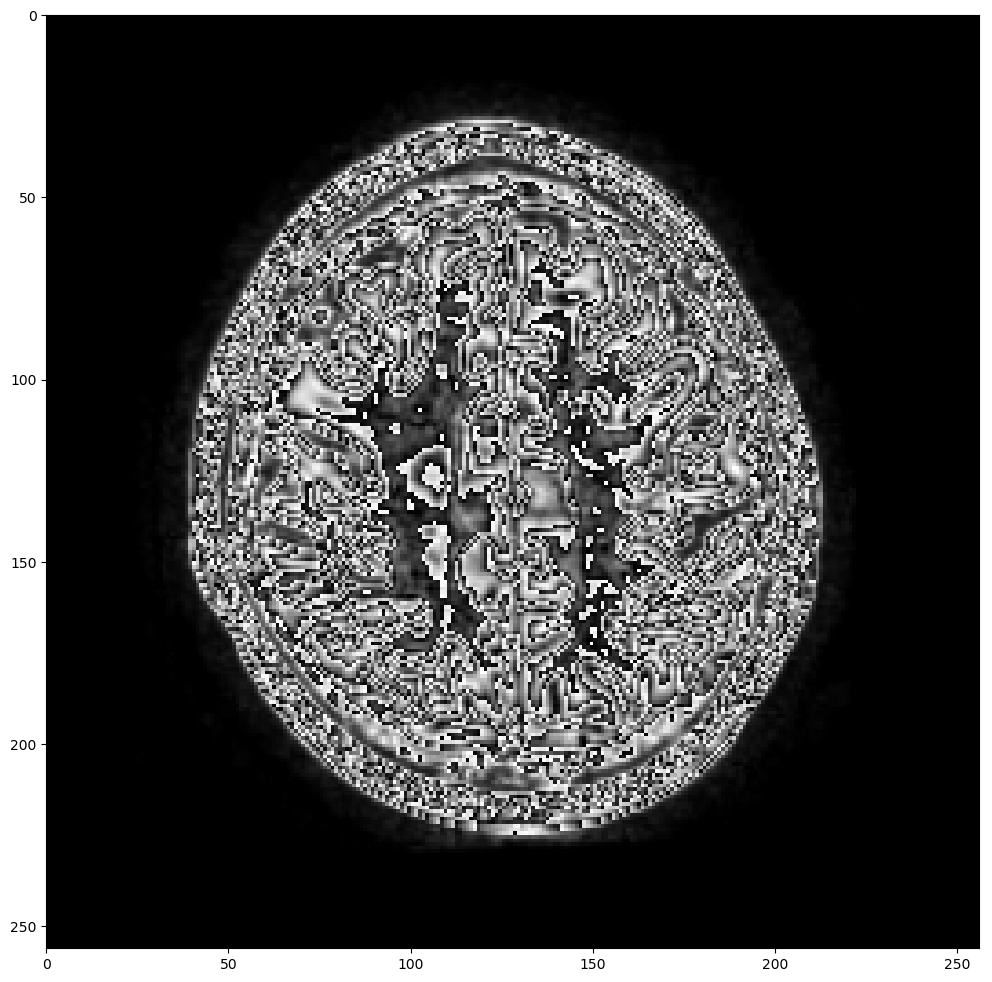

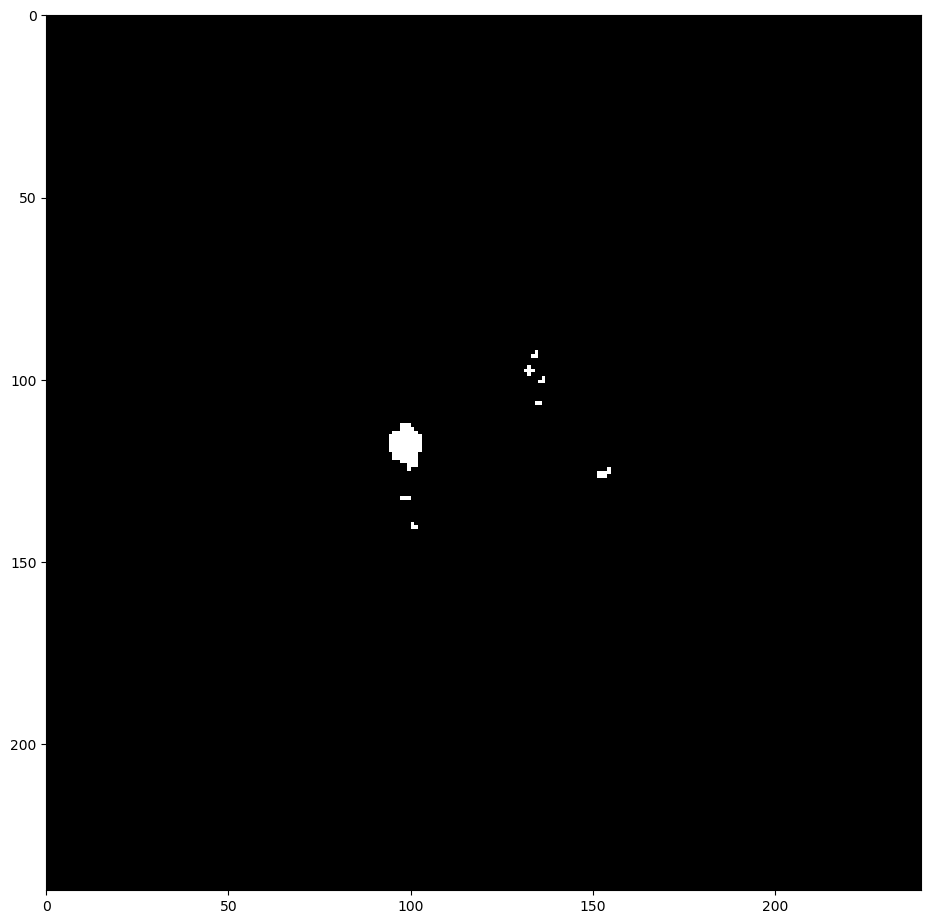

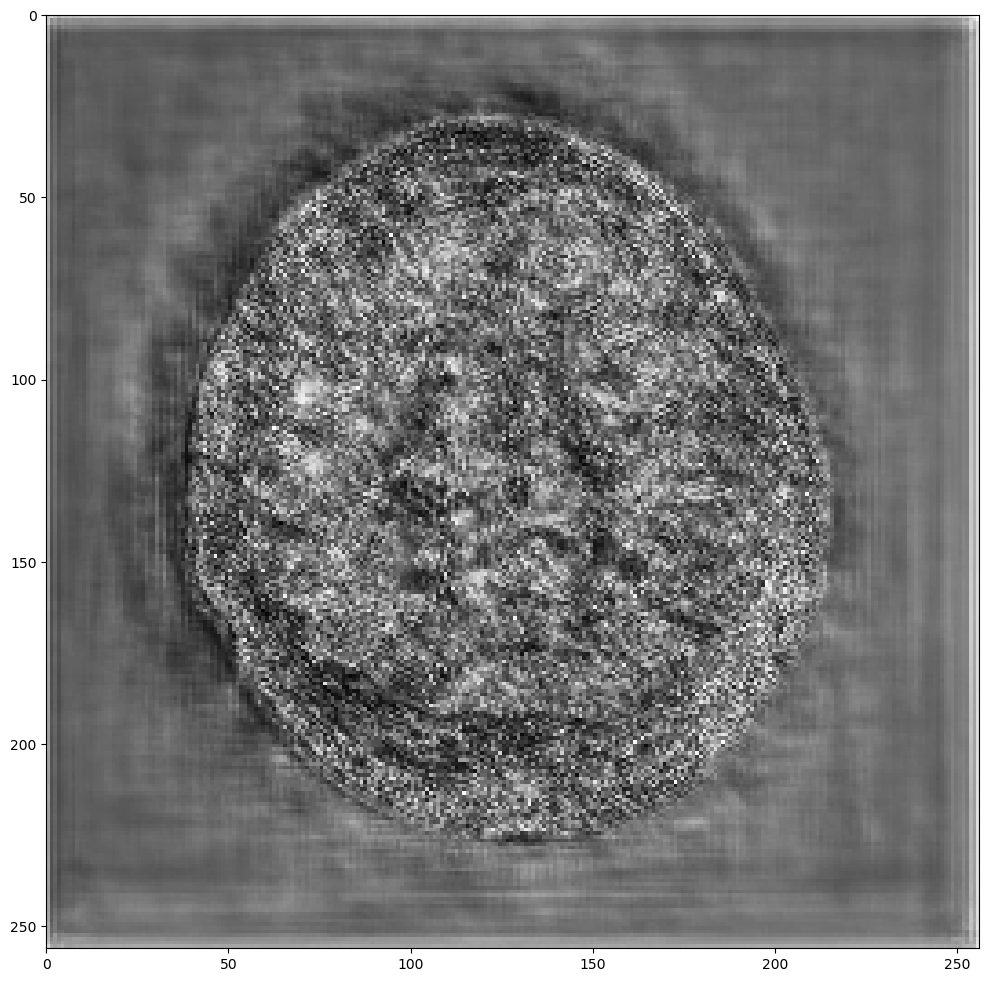

In [44]:
testFilename, resultFilename = predict(model)

In [107]:
testFilename.shape

(138, 240, 240, 1)

In [108]:
resultFilename.shape

(138, 240, 240, 1)

## Evaluation


In [109]:
import difflib
import numpy as np
import os
import SimpleITK as sitk
import scipy.spatial

# # Set the path to the source data (e.g. the training data for self-testing)
# # and the output directory of that subject
# testDir = '../data/validation/Utrecht' # For example: '/data/Utrecht/0'
# participantDir = 'preds/' # For example: '/output/teamname/0'

In [110]:
def do():
    """Main function"""
#     resultFilename = getResultFilename(participantDir)
    testImage, resultImage = getImages(testFilename, resultFilename)
    dsc = getDSC(testImage, resultImage)
    h95 = getHausdorff(testImage, resultImage)
    avd = getAVD(testImage, resultImage)
    recall, f1 = getLesionDetection(testImage, resultImage)
    print ('Dice', dsc, '(higher is better, max=1)')
    print ('HD', h95, 'mm', '(lower is better, min=0)')
    print ('AVD', avd, '%', '(lower is better, min=0)')
    print ('Lesion detection', recall, '(higher is better, max=1)')
    print ('Lesion F1', f1, '(higher is better, max=1)')

In [131]:
def getImages(testImage, resultImage):
    """Return the test and result images, thresholded and non-WMH masked."""
#     testImage = sitk.ReadImage(testFilename)
#     resultImage = sitk.ReadImage(resultFilename)
#     # Check for equality
    testImage= sitk.GetImageFromArray(testImage)[30,:,:]
    resultImage= sitk.GetImageFromArray(resultImage)[30,:,:]
#     assert testImage.GetSize() == resultImage.GetSize()
    # Get meta data from the test-image, needed for some sitk methods that check this
    
    resultImage.CopyInformation(testImage)
    # Remove non-WMH from the test and result images, since we don't evaluate on that
    print(type(testImage), sitk.GetArrayFromImage(testImage).shape,sitk.GetArrayFromImage(testImage).max())
    maskedTestImage = sitk.BinaryThreshold(testImage, 0.5, 1.5, 1, 0) # WMH == 1
    nonWMHImage = sitk.BinaryThreshold(testImage, 1.5, 2.5, 0, 1) # non-WMH == 2
    maskedResultImage = sitk.Mask(resultImage, nonWMHImage)
    # Convert to binary mask
    if 'integer' in maskedResultImage.GetPixelIDTypeAsString():
        bResultImage = sitk.BinaryThreshold(maskedResultImage, 1, 1000, 1, 0)
    else:
        bResultImage = sitk.BinaryThreshold(maskedResultImage, 0.5, 1000, 1, 0)
    return maskedTestImage, bResultImage

In [112]:
def getResultFilename(participantDir):
    """Find the filename of the result image.
    This should be result.nii.gz or result.nii. If these files are not present,
    it tries to find the closest filename."""
    files = os.listdir(participantDir)
    if not files:
        raise Exception("No results in "+ participantDir)
        resultFilename = None
    if 'result.nii.gz' in files:
        resultFilename = os.path.join(participantDir, 'result.nii.gz')
    elif 'result.nii' in files:
        resultFilename = os.path.join(participantDir, 'result.nii')
    else:
        # Find the filename that is closest to 'result.nii.gz'
        maxRatio = -1
    for f in files:
        currentRatio = difflib.SequenceMatcher(a = f, b = 'result.nii.gz').ratio()
        if currentRatio > maxRatio:
            resultFilename = os.path.join(participantDir, f)
            maxRatio = currentRatio
    return resultFilename

In [113]:
def getDSC(testImage, resultImage):
    """Compute the Dice Similarity Coefficient."""
    testArray = sitk.GetArrayFromImage(testImage).flatten()
    resultArray = sitk.GetArrayFromImage(resultImage).flatten()
    # similarity = 1.0 - dissimilarity
    return 1.0 - scipy.spatial.distance.dice(testArray, resultArray)

In [114]:
def getHausdorff(testImage, resultImage):
    """Compute the Hausdorff distance."""
    # Hausdorff distance is only defined when something is detected
    resultStatistics = sitk.StatisticsImageFilter()
    resultStatistics.Execute(resultImage)
    if resultStatistics.GetSum() == 0:
        return float('nan')

    # Edge detection is done by ORIGINAL - ERODED, keeping the outer boundaries of lesions. Erosion is performed in 2D
    eTestImage = sitk.BinaryErode(testImage, (1,1,0) )
    eResultImage = sitk.BinaryErode(resultImage, (1,1,0) )
    hTestImage = sitk.Subtract(testImage, eTestImage)
    hResultImage = sitk.Subtract(resultImage, eResultImage)
    hTestArray = sitk.GetArrayFromImage(hTestImage)
    hResultArray = sitk.GetArrayFromImage(hResultImage)
    # Convert voxel location to world coordinates. Use the coordinate system of the test image
    # np.nonzero = elements of the boundary in numpy order (zyx)
    # np.flipud = elements in xyz order
    # np.transpose = create tuples (x,y,z)
    # testImage.TransformIndexToPhysicalPoint converts (xyz) to world coordinates (in mm)
    testCoordinates = np.apply_along_axis(testImage.TransformIndexToPhysicalPoint, 1, np.transpose( np.flipud( np.nonzero(hTestArray) )).astype(int) )
    resultCoordinates = np.apply_along_axis(testImage.TransformIndexToPhysicalPoint, 1, np.transpose( np.flipud( np.nonzero(hResultArray) )).astype(int) )
    
    # Use a kd-tree for fast spatial search
    def getDistancesFromAtoB(a, b):
        kdTree = scipy.spatial.KDTree(a, leafsize=100)
        return kdTree.query(b, k=1, eps=0, p=2)[0]
    
    # Compute distances from test to result; and result to test
    dTestToResult = getDistancesFromAtoB(testCoordinates, resultCoordinates)
    dResultToTest = getDistancesFromAtoB(resultCoordinates, testCoordinates)
    
    return max(np.percentile(dTestToResult, 95), np.percentile(dResultToTest, 95))

In [115]:
def getLesionDetection(testImage, resultImage):
    """Lesion detection metrics, both recall and F1."""
    # Connected components will give the background label 0, so subtract 1 from all results
    ccFilter = sitk.ConnectedComponentImageFilter()
    ccFilter.SetFullyConnected(True)
    # Connected components on the test image, to determine the number of true WMH.
    # And to get the overlap between detected voxels and true WMH
    ccTest = ccFilter.Execute(testImage)
    lResult = sitk.Multiply(ccTest, sitk.Cast(resultImage, sitk.sitkUInt32))
    ccTestArray = sitk.GetArrayFromImage(ccTest)
    lResultArray = sitk.GetArrayFromImage(lResult)
    # recall = (number of detected WMH) / (number of true WMH)
    nWMH = len(np.unique(ccTestArray)) - 1
    if nWMH == 0:
        recall = 1.0
    else:
        recall = float(len(np.unique(lResultArray)) - 1) / nWMH
    # Connected components of results, to determine number of detected lesions
    ccResult = ccFilter.Execute(resultImage)
    lTest = sitk.Multiply(ccResult, sitk.Cast(testImage, sitk.sitkUInt32))
    ccResultArray = sitk.GetArrayFromImage(ccResult)
    lTestArray = sitk.GetArrayFromImage(lTest)
    # precision = (number of detections that intersect with WMH) / (number of all detections)
    nDetections = len(np.unique(ccResultArray)) - 1
    if nDetections == 0:
        precision = 1.0
    else:
        precision = float(len(np.unique(lTestArray)) - 1) / nDetections
    if precision + recall == 0.0:
        f1 = 0.0
    else:
        f1 = 2.0 * (precision * recall) / (precision + recall)
    return recall, f1

In [116]:
def getAVD(testImage, resultImage):
    """Volume statistics."""
    # Compute statistics of both images
    testStatistics = sitk.StatisticsImageFilter()
    resultStatistics = sitk.StatisticsImageFilter()
    testStatistics.Execute(testImage)
    resultStatistics.Execute(resultImage)
    return float(abs(testStatistics.GetSum() - resultStatistics.GetSum())) / float(testStatistics.GetSum()) * 100

In [117]:
# def zero_padding_3d(x: np.array, p = 1):
#     z0 = np.zeros((p, x.shape[1], x.shape[2]), dtype=x.dtype)
#     z1 = np.zeros((x.shape[0] + p*2, p, x.shape[2]), dtype=x.dtype)
#     x_padded = np.concatenate((z1, np.concatenate((z0, x, z0), axis=0), z1), axis=1)
#     return x_padded

# zero_padding_3d(x, p=1).shape

In [132]:
if __name__ == "__main__":
    do()

<class 'SimpleITK.SimpleITK.Image'> (138, 240) 0


RuntimeError: Exception thrown in SimpleITK BinaryThreshold: c:\users\dashboard\miniconda3\conda-bld\simpleitk_1521730316398\work\code\common\include\sitkMemberFunctionFactory.hxx:209:
sitk::ERROR: Pixel type: vector of 32-bit signed integer is not supported in 2D byclass itk::simple::BinaryThresholdImageFilter

In [90]:

x = np.array([
        [
            [1, 0, 1, 1, 2], 
            [1, 2, 1, 2, 1],
            [0, 0, 2, 1, 1],
            [0, 1, 0, 1, 2],
            [2, 0, 2, 1, 0]
        ],
        [
            [0, 0, 1, 2, 0],
            [0, 0, 0, 1, 1],
            [0, 0, 0, 2, 2],
            [2, 1, 2, 2, 2],
            [2, 1, 2, 1, 0]
        ],
        [
            [0, 0, 2, 2, 1],
            [0, 2, 1, 0, 2],
            [1, 2, 0, 1, 1],
            [0, 2, 1, 1, 2],
            [2, 0, 0, 1, 1]
        ]
        ]).transpose(1, 2, 0)
        
def zero_padding_3d(x: np.array, p = 1):
    z0 = np.zeros((p, x.shape[1], x.shape[2]), dtype=x.dtype)
    z1 = np.zeros((x.shape[0] + p*2, p, x.shape[2]), dtype=x.dtype)
    x_padded = np.concatenate((z1, np.concatenate((z0, x, z0), axis=0), z1), axis=1)
    return x_padded
    
for i in range(testFilename.shape[0]):
    test = np.concatenate(test,zero_padding_3d(testFilename[i,:,:,:], p=1)[:, :, :])
print (testFilename[i,:,:,:].shape,test.shape)

TypeError: only integer scalar arrays can be converted to a scalar index

In [83]:
testFilename.shape

(138, 240, 240, 1)

In [88]:
x = np.array([
        [
            [1, 0, 1, 1, 2], 
            [1, 2, 1, 2, 1],
            [0, 0, 2, 1, 1],
            [0, 1, 0, 1, 2],
            [2, 0, 2, 1, 0]
        ],
        [
            [0, 0, 1, 2, 0],
            [0, 0, 0, 1, 1],
            [0, 0, 0, 2, 2],
            [2, 1, 2, 2, 2],
            [2, 1, 2, 1, 0]
        ],
        [
            [0, 0, 2, 2, 1],
            [0, 2, 1, 0, 2],
            [1, 2, 0, 1, 1],
            [0, 2, 1, 1, 2],
            [2, 0, 0, 1, 1]
        ]
        ]).transpose(1, 2, 0)
        
def zero_padding_3d(x: np.array, p = 1):
    z0 = np.zeros((p, x.shape[1], x.shape[2]), dtype=x.dtype)
    z1 = np.zeros((x.shape[0] + p*2, p, x.shape[2]), dtype=x.dtype)
    x_padded = np.concatenate((z1, np.concatenate((z0, x, z0), axis=0), z1), axis=1)
    return x_padded
    
yy = zero_padding_3d(x, p=1)[:, :, :]
print(x.shape,yy.shape)

(5, 5, 3) (7, 7, 3)
